In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from google.colab import files


delta_t = 0.32
t_iters = 20

In [ ]:
# function for saving figures
def save_and_download_fig(title):
  plt.savefig(f"{title}.png", dpi=500)
  files.download(f"{title}.png") 

### Generating data 

In [ ]:
def generate_harmonic_oscillator_dataset(x_dim=1,n_seq=500, t_iters=20, v_0=0, delta_t=0.1):
  x_ = np.zeros((n_seq, t_iters,x_dim))
  for j in range(n_seq):
    x_[j][0] = np.random.uniform(low=[0]*x_dim, high=[1]*x_dim, size=(x_dim,))
    x_[j][1] = x_[j][0] + v_0*delta_t - 0.5*x_[j][0]*delta_t**2
    for i in range(2,t_iters):
      x_[j][i]=2*x_[j][i-1]-x_[j][i-2]-x_[j][i-1]*delta_t**2
  
  return x_

# divide the generated data to train and test
def divide_data(x):
  indices = np.arange(len(x))
  np.random.shuffle(indices)
  train = x[indices[:len(x)*4//5]]
  test = x[indices[len(x)*4//5:]]
  return train, test


all_generated_data = generate_harmonic_oscillator_dataset(x_dim=1,delta_t=delta_t, t_iters=t_iters+1)
train, test = divide_data(all_generated_data)

### Plotting one of the genereted sequences

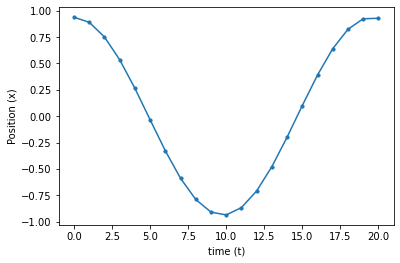

In [ ]:
x_plot = all_generated_data[0].ravel()
plt.scatter(np.arange(len(x_plot)), x_plot, s=10, label='original')
plt.plot(np.arange(len(x_plot)), x_plot)

plt.ylabel("Position (x)")
plt.xlabel("time (t)")
#plt.legend()
#save_and_download_fig("series0_x(t)")
plt.show()


# Task 1 - phase portrait of the generated data

In [ ]:
v_ = np.zeros(all_generated_data.shape)
for i in range(len(all_generated_data)):
  v_[i,1:] = [(all_generated_data[i][j+1]-all_generated_data[i][j])/delta_t for j in range(len(all_generated_data[i])-1)]



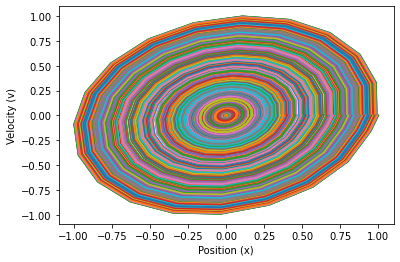

In [ ]:
for i in range(len(all_generated_data)):
  plt.plot(all_generated_data[i], v_[i])
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
# plt.title("Phase portrait of the generated data with first degree taylor estimation")
#save_and_download_fig("phase_portrait_taylor")
# plt.legend()
plt.show()


In [ ]:
v_1 = np.zeros(all_generated_data.shape)
for i in range(len(all_generated_data)):
  v_1[i,1:] = [-all_generated_data[i,0]*np.sin(delta_t*j) for j in range(1,len(all_generated_data[i]))]
  

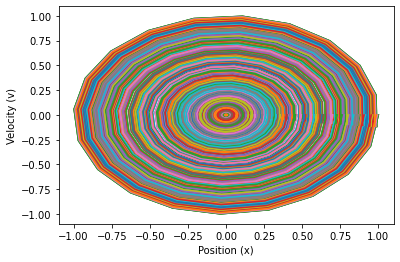

In [ ]:
for i in range(len(all_generated_data)):
  plt.plot(all_generated_data[i], v_1[i])
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
# plt.title("Phase portrait of the generated data with the velocity equation of the Harmonic oscillator")
#save_and_download_fig("phase_portrait_formula")
# plt.legend()
plt.show()


### RNN 

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print(device)
    print(f"GPU is available - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

cuda
GPU is available - Tesla T4


In [ ]:
from torch import nn, optim


# number of points
hidden_size = 100
input_size = 1
number_of_layers = 2
output_size = 1
lr = 0.001
n_epochs=100


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.number_of_layers = number_of_layers
        self.output_size = output_size

        self.rnn = nn.RNN(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.number_of_layers,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hidden_prev):
        #h0 = self.init_hidden_state() # we found out that it is better not to reinialized 
        hidden_prev = hidden_prev.to(device)
        #out, hidden_prev = self.rnn(x, h0)
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, self.hidden_size)  # stack batch and seq
        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev
    
    def init_hidden_state(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        initial_hidden = torch.zeros(self.number_of_layers, self.input_size, self.hidden_size).to(device) # [b, layer, mem_size]
        return initial_hidden

### Training

In [ ]:
def calculate_prdiction_error(data_set_x, data_set_y, losses_lst, epoch, name, number_of_epochs, hidden_prev):
    with torch.no_grad():
      tmp_loss = 0
      for i in range(len(data_set_x)):
        y_pred, hidden_prev = model(data_set_x[i].to(device), hidden_prev)
        tmp_loss += float(criterion(y_pred, data_set_y[i].to(device)).cpu())
        # model.eval()
        # y_pred = model(test)
        # test_loss = criterion(y_pred, testY)
      epoch_loss = tmp_loss/len(data_set_x)
      losses_lst.append(epoch_loss)
      print(f'epoch {epoch}/{number_of_epochs}: {name} dataset loss is {epoch_loss}')


In [ ]:
model = Net()
model = model.to(device)
hidden_prev = model.init_hidden_state()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

train_losses = []
test_losses = []

train_x = torch.tensor(train[:,:-1]).float().reshape(len(train), 1, len(train[0]) - 1, 1)  # [b, seq_len, fea_len]
train_y = torch.tensor(train[:,1:]).float().reshape(len(train), 1, len(train[0]) - 1, 1)  # [b, seq_len, fea_len]

test_x = torch.tensor(test[:,:-1]).float().reshape(len(test), 1, len(test[0]) - 1, 1)  # [b, seq_len, fea_len]
test_y = torch.tensor(test[:,1:]).float().reshape(len(test), 1, len(test[0]) - 1, 1)  # [b, seq_len, fea_len]

start = time.time()
for epoch in range(1,n_epochs+1):
  for iter in range(len(train_x)):
    
    # # x: 20 points 0-19; y: 20 points 1-20
    # x = torch.tensor(seq[:-1]).float().reshape(1, len(seq) - 1, 1)  # [b, seq_len, fea_len]
    # y = torch.tensor(seq[1:]).float().reshape(1, len(seq) - 1, 1)  # [b, seq_len, fea_len]
    #index = int(np.random.randint(low=0, high=len(train_x), size=1))
    x = train_x[iter]
    x = x.to(device)
    y = train_y[iter]
    y = y.to(device)
    
    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    # print(f"output {output.shape}, y {y.shape}")
    loss = criterion(output, y)
    
    # model.zero_grad()
    # both zero_grad() are the same if model.parameters() is feed to the same optimizer
    # only matters if multiple models using same optimizer or multiple optims used for a model
    model.zero_grad()
    loss.backward()
    optimizer.step()

    # print(f"iteration: {iter}, loss {loss.item()}")

  tmp_loss = 0
  

  calculate_prdiction_error(data_set_x=train_x, data_set_y=train_y,
                     losses_lst=train_losses,
                     epoch= epoch, name='Train', number_of_epochs=n_epochs,
                     hidden_prev=hidden_prev)
  calculate_prdiction_error(data_set_x=test_x, data_set_y=test_y,
                     losses_lst=test_losses,
                     epoch= epoch, name='Test', number_of_epochs=n_epochs,
                     hidden_prev=hidden_prev)
  end_epoch = time.time()
  print(f'runing time: {round(end_epoch - start,4)} sec')
  print()
end_train = time.time()
print(f'Total Training time: {round(end_train - start,4)} sec')
  




epoch 1/100: Train dataset loss is 0.0012754851816862355
epoch 1/100: Test dataset loss is 0.0012629818233835977
runing time: 1.0221 sec

epoch 2/100: Train dataset loss is 0.0009488127796612389
epoch 2/100: Test dataset loss is 0.0009191208505217219
runing time: 1.9864 sec

epoch 3/100: Train dataset loss is 0.0007969023807072517
epoch 3/100: Test dataset loss is 0.0007853340422298061
runing time: 2.9929 sec

epoch 4/100: Train dataset loss is 0.0016021911658754106
epoch 4/100: Test dataset loss is 0.0015826598333660512
runing time: 3.9647 sec

epoch 5/100: Train dataset loss is 0.0007813061086812922
epoch 5/100: Test dataset loss is 0.0007658428502691094
runing time: 4.9326 sec

epoch 6/100: Train dataset loss is 0.0009242062202042689
epoch 6/100: Test dataset loss is 0.0009207353257443174
runing time: 5.8775 sec

epoch 7/100: Train dataset loss is 0.001207607385385927
epoch 7/100: Test dataset loss is 0.0012026044914091472
runing time: 6.8522 sec

epoch 8/100: Train dataset loss is 

# Task 2 - Prediction error at the end of each epoch: train and test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

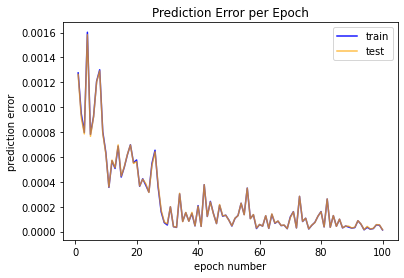

In [ ]:
np_arr_epoch = np.arange(1, n_epochs+1)
plt.plot(np_arr_epoch, train_losses, label='train', alpha=0.9, color = 'blue')
plt.plot(np_arr_epoch, test_losses, label='test', alpha=0.7, color = 'orange')

plt.xlabel('epoch number')
plt.ylabel('prediction error')
plt.title('Prediction Error per Epoch')


plt.legend()
#save_and_download_fig("Losses_line")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

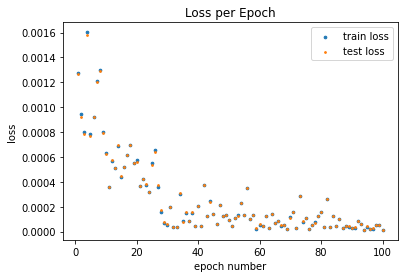

In [ ]:
## As a scatter
plt.scatter(np_arr_epoch, train_losses, label='train', s=7)
plt.scatter(np_arr_epoch, test_losses, label='test', s=3)

plt.xlabel('epoch number')
plt.ylabel('prediction error')
plt.title('Prediction Error per Epoch')


plt.legend()
#save_and_download_fig("Losses")
plt.show()

### Plotting one of the prediction sequences

inference time: 0.0353 sec


/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

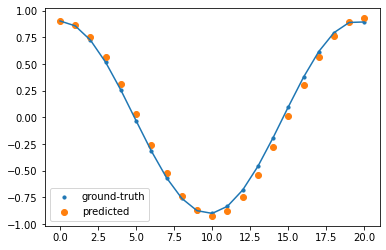

In [ ]:
check = torch.tensor(all_generated_data[18]).float().reshape(1, len(all_generated_data[0]), 1)
preds = []
input_check = check[:, 0, :]  # select first point
preds.append(input_check)
with torch.no_grad():
    start_inference = time.time()
    model.eval()
    for _ in range(check.shape[1]-1):
        input_check = input_check.reshape(1, 1, 1)  # reshape it for model feeding
        input_check = input_check.to(device)
        pred, hidden_prev = model(input_check, hidden_prev)

        input_check = pred
        preds.append(pred.detach().cpu().numpy().ravel()[0])
    end_inference = time.time()
    print(f'inference time: {round(end_inference - start_inference,4)} sec')
check = check.data.numpy().ravel()
plt.scatter(np.arange(len(check)), check.ravel(), s=10, label='ground-truth')
plt.plot(np.arange(len(check)), check.ravel())

plt.scatter(np.arange(len(check)), preds, label='predicted')


plt.legend()
#save_and_download_fig("Prediction_example")
plt.show()

# Task 3 - phase portrait of the learned space

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

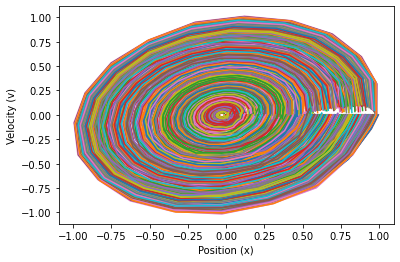

In [ ]:
# Phase portrait of the learned space out of 500 samples, 500 for convenience
samples_number = 500
x_0_samples = torch.tensor(np.random.uniform(low=0, high=1, size=(samples_number))).float()

for input_x0 in x_0_samples:
  preds = []

  preds.append(input_x0)
  with torch.no_grad():
    model.eval()
    for _ in range(1, t_iters+1):
        input_x0 = input_x0.reshape(1, 1, 1)  # reshape it for model feeding
        input_x0 = input_x0.to(device)
        pred, hidden_prev = model(input_x0, hidden_prev)

        input_x0 = pred
        preds.append(pred.detach().cpu().numpy().ravel()[0])

    # velo_preds[1:] = [-preds[i,0]*np.sin(delta_t*j) for j in range(1,len(all_generated_data[i]))]
    velo_preds = [0]+[(preds[j+1]-preds[j])/delta_t for j in range(len(preds)-1)]
    plt.plot(preds, velo_preds)



plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
# plt.title("Phase portrait of the learned space with first degree taylor estimation of the velocity")
#plt.legend()
#save_and_download_fig("Phase_portrait_learned_space")

plt.show()